# INSTALL DEPEDENSI

In [1]:
!pip install xgboost scikit-learn-intelex

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.3/4.3 MB 41.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.3/110.3 MB 5.9 MB/s eta 0:00:00


# LOAD DRIVE UNTUK SIMPAN DATA ATAU LOAD DATA

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# IMPORT DEPEDENSI

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures
from sklearn.impute import SimpleImputer
from sklearn.metrics import roc_auc_score, roc_curve
from xgboost import XGBClassifier

sns.set(style='whitegrid')

# LOAD DATASET

In [ ]:
try:
    train_df = pd.read_csv("/content/drive/MyDrive/KURSUS ARTIFICIAL INTELEGENT/Lomba Machine Learning/training_dataset.csv")
    val_df = pd.read_csv("/content/drive/MyDrive/KURSUS ARTIFICIAL INTELEGENT/Lomba Machine Learning/validation_set.csv") 
    print("Dataset berhasil dimuat!")
except FileNotFoundError:
    print("Pastikan 'training_dataset.csv' dan 'validation_set.csv' ada di direktori yang sama.")
    exit()

Dataset berhasil dimuat!


# PreProcessing 1

In [5]:
TARGET = 'berlangganan_deposito'
X = train_df.drop(columns=["customer_number", TARGET])
y = train_df[TARGET]

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

print(f"\nJumlah data training (internal): {len(X_train)}")
print(f"Jumlah data testing (internal): {len(X_test)}")
print(f"Distribusi kelas target di training (internal):\n{y_train.value_counts()}")
print(f"Distribusi kelas target di testing (internal):\n{y_test.value_counts()}")
print(f"Jumlah data validation (untuk prediksi akhir): {len(val_df)}")


Jumlah data training (internal): 18332
Jumlah data testing (internal): 4584
Distribusi kelas target di training (internal):
berlangganan_deposito
0    16241
1     2091
Name: count, dtype: int64
Distribusi kelas target di testing (internal):
berlangganan_deposito
0    4061
1     523
Name: count, dtype: int64
Jumlah data validation (untuk prediksi akhir): 5729


# ENGINEER FEATURES

In [ ]:

def engineer_features(df):
    df_copy = df.copy()
    df_copy['had_previous_contact'] = (df_copy['hari_sejak_kontak_sebelumnya'] != 999).astype(int)

    df_copy['age_x_campaign_contacts'] = df_copy['usia'] * df_copy['jumlah_kontak_kampanye_ini']

    df_copy['usia_binned'] = pd.cut(df_copy['usia'], bins=[18, 30, 40, 50, 60, np.inf], labels=['18-29', '30-39', '40-49', '50-59', '60+'], right=False)
    df_copy['usia_binned'] = df_copy['usia_binned'].astype(object) 

    df_copy['prev_contact_ratio'] = df_copy['jumlah_kontak_sebelumnya'] / (df_copy['jumlah_kontak_kampanye_ini'] + 1e-6)

    df_copy['recent_contact'] = (df_copy['hari_sejak_kontak_sebelumnya'] > 0) & (df_copy['hari_sejak_kontak_sebelumnya'] <= 7)
    df_copy['recent_contact'] = df_copy['recent_contact'].astype(int)

    df_copy['pekerjaan_pendidikan_interaksi'] = df_copy['pekerjaan'] + '_' + df_copy['pendidikan']
    df_copy['pekerjaan_pendidikan_interaksi'] = df_copy['pekerjaan_pendidikan_interaksi'].astype(object)
    df_copy['euribor_x_icc'] = df_copy['suku_bunga_euribor_3bln'] * df_copy['indeks_kepercayaan_konsumen']

    df_copy['jumlah_pekerja_x_tingkat_variasi'] = df_copy['jumlah_pekerja'] * df_copy['tingkat_variasi_pekerjaan']

    df_copy['memiliki_pinjaman'] = ((df_copy['pinjaman_rumah'] == 'yes') | (df_copy['pinjaman_pribadi'] == 'yes')).astype(int)

    df_copy['usia_binned_x_status_perkawinan'] = df_copy['usia_binned'].astype(str) + '_' + df_copy['status_perkawinan']
    df_copy['usia_binned_x_status_perkawinan'] = df_copy['usia_binned_x_status_perkawinan'].astype(object)

    if 'durasi_kontak_terakhir' in df_copy.columns:
        df_copy['durasi_binned'] = pd.cut(df_copy['durasi_kontak_terakhir'], bins=[-1, 60, 180, 300, 600, np.inf], labels=['<1min', '1-3min', '3-5min', '5-10min', '>10min'], right=False)
        df_copy['durasi_binned'] = df_copy['durasi_binned'].astype(object)
    else:
        pass
    df_copy['hasil_kampanye_x_jenis_kontak'] = df_copy['hasil_kampanye_sebelumnya'] + '_' + df_copy['jenis_kontak']
    df_copy['hasil_kampanye_x_jenis_kontak'] = df_copy['hasil_kampanye_x_jenis_kontak'].astype(object)
    df_copy['usia_binned_x_jenis_kontak'] = df_copy['usia_binned'].astype(str) + '_' + df_copy['jenis_kontak']
    df_copy['usia_binned_x_jenis_kontak'] = df_copy['usia_binned_x_jenis_kontak'].astype(object)
    df_copy['pendidikan_x_hasil_kampanye'] = df_copy['pendidikan'] + '_' + df_copy['hasil_kampanye_sebelumnya']
    df_copy['pendidikan_x_hasil_kampanye'] = df_copy['pendidikan_x_hasil_kampanye'].astype(object)
    df_copy['status_keuangan_gabungan'] = df_copy['gagal_bayar_sebelumnya'].astype(str) + '_' + \
                                          df_copy['pinjaman_rumah'].astype(str) + '_' + \
                                          df_copy['pinjaman_pribadi'].astype(str)
    df_copy['status_keuangan_gabungan'] = df_copy['status_keuangan_gabungan'].astype(object)
    df_copy['bulan_kontak_x_hasil_kampanye'] = df_copy['bulan_kontak_terakhir'] + '_' + df_copy['hasil_kampanye_sebelumnya']
    df_copy['bulan_kontak_x_hasil_kampanye'] = df_copy['bulan_kontak_x_hasil_kampanye'].astype(object)
    df_copy['prev_contact_to_total_ratio'] = df_copy['jumlah_kontak_sebelumnya'] / (df_copy['jumlah_kontak_sebelumnya'] + df_copy['jumlah_kontak_kampanye_ini'] + 1e-6)

    return df_copy

X_train = engineer_features(X_train)
X_test = engineer_features(X_test)
val_df_processed = engineer_features(val_df.drop(columns=["customer_number"])) 

print("\nFitur rekayasa tambahan yang lebih dalam berhasil dibuat.")


Fitur rekayasa tambahan yang lebih dalam berhasil dibuat.


# IDENTIFICATION

In [7]:

numerical_features = X_train.select_dtypes(include=np.number).columns.tolist()
categorical_features = X_train.select_dtypes(include='object').columns.tolist()
for binned_feature in ['usia_binned', 'durasi_binned']:
    if binned_feature in numerical_features:
        numerical_features.remove(binned_feature)
        if binned_feature not in categorical_features:
            categorical_features.append(binned_feature)
    elif binned_feature not in categorical_features and binned_feature in X_train.columns:
        categorical_features.append(binned_feature)

print(f"\nFitur Numerik yang Diperbarui: {numerical_features}")
print(f"Fitur Kategorikal yang Diperbarui: {categorical_features}")

features_to_drop_from_modeling = [
    'pinjaman_rumah',
    'pinjaman_pribadi',
    'gagal_bayar_sebelumnya',
    'hari_kontak_terakhir',
    'pulau',
]


numerical_features_filtered = [f for f in numerical_features if f not in features_to_drop_from_modeling]
categorical_features_filtered = [f for f in categorical_features if f not in features_to_drop_from_modeling]

print(f"\nFitur yang akan dihapus dari model: {features_to_drop_from_modeling}")
print(f"Fitur Numerik setelah filter: {numerical_features_filtered}")
print(f"Fitur Kategorikal setelah filter: {categorical_features_filtered}")


Fitur Numerik yang Diperbarui: ['usia', 'jumlah_kontak_kampanye_ini', 'hari_sejak_kontak_sebelumnya', 'jumlah_kontak_sebelumnya', 'tingkat_variasi_pekerjaan', 'indeks_harga_konsumen', 'indeks_kepercayaan_konsumen', 'suku_bunga_euribor_3bln', 'jumlah_pekerja', 'had_previous_contact', 'age_x_campaign_contacts', 'prev_contact_ratio', 'recent_contact', 'euribor_x_icc', 'jumlah_pekerja_x_tingkat_variasi', 'memiliki_pinjaman', 'prev_contact_to_total_ratio']
Fitur Kategorikal yang Diperbarui: ['pekerjaan', 'status_perkawinan', 'pendidikan', 'gagal_bayar_sebelumnya', 'pinjaman_rumah', 'pinjaman_pribadi', 'jenis_kontak', 'bulan_kontak_terakhir', 'hari_kontak_terakhir', 'hasil_kampanye_sebelumnya', 'pulau', 'usia_binned', 'pekerjaan_pendidikan_interaksi', 'usia_binned_x_status_perkawinan', 'hasil_kampanye_x_jenis_kontak', 'usia_binned_x_jenis_kontak', 'pendidikan_x_hasil_kampanye', 'status_keuangan_gabungan', 'bulan_kontak_x_hasil_kampanye']

Fitur yang akan dihapus dari model: ['pinjaman_rumah

#PREPROCESSING 2

In [8]:

numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('poly', PolynomialFeatures(degree=2, include_bias=False, interaction_only=True)),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features_filtered),
        ('cat', categorical_transformer, categorical_features_filtered)
    ],
    remainder='drop'
)

# IMBALANCE SOLUTION

In [9]:
neg_count = y_train.value_counts()[0]
pos_count = y_train.value_counts()[1]
scale_pos_weight_value = neg_count / pos_count
print(f"\nscale_pos_weight yang direkomendasikan: {scale_pos_weight_value:.2f}")


scale_pos_weight yang direkomendasikan: 7.77


# Tuning XGBOOST

In [ ]:
results = {}
submission_dfs = {}

print("\n Memulai Tuning XGBoost")
xgb_model = XGBClassifier(
    objective='binary:logistic',
    eval_metric='auc',
    device='cpu',
    random_state=42,
    scale_pos_weight=scale_pos_weight_value,
)

xgb_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', xgb_model)
])

xgb_param_dist = {
    'classifier__n_estimators': [60, 70, 75, 80, 90, 100], 
    'classifier__learning_rate': [0.04, 0.045, 0.05, 0.055, 0.06], 
    'classifier__max_depth': [3, 4, 5], 
    'classifier__subsample': [0.65, 0.7, 0.75],
    'classifier__colsample_bytree': [0.6, 0.65, 0.7], 
    'classifier__gamma': [0.1, 0.125, 0.15, 0.175, 0.2] 
}
xgb_random_search = RandomizedSearchCV(
    estimator=xgb_pipeline,
    param_distributions=xgb_param_dist,
    n_iter=200,
    scoring='roc_auc',
    cv=5,
    verbose=2,
    random_state=42,
    n_jobs=-1
)
xgb_random_search.fit(X_train, y_train)
results['XGBoost'] = {
    'best_params': xgb_random_search.best_params_,
    'best_cv_auc': xgb_random_search.best_score_,
    'test_auc': roc_auc_score(y_test, xgb_random_search.predict_proba(X_test)[:, 1])
}
best_xgb_estimator = xgb_random_search.best_estimator_
submission_dfs['XGBoost'] = pd.DataFrame({
    "customer_number": val_df["customer_number"],
    "deposito_probabilitas": best_xgb_estimator.predict_proba(val_df_processed)[:, 1]
})
print(f"XGBoost Best Test AUC: {results['XGBoost']['test_auc']:.4f}")



 Memulai Tuning XGBoost
Fitting 5 folds for each of 200 candidates, totalling 1000 fits
XGBoost Best Test AUC: 0.7937


# Overview


 Ringkasan Hasil Tuning Model

Model: XGBoost
   Best CV AUC: 0.7987
   Test AUC: 0.7937
   Best Parameters: {'classifier__subsample': 0.65, 'classifier__n_estimators': 70, 'classifier__max_depth': 4, 'classifier__learning_rate': 0.045, 'classifier__gamma': 0.1, 'classifier__colsample_bytree': 0.65}


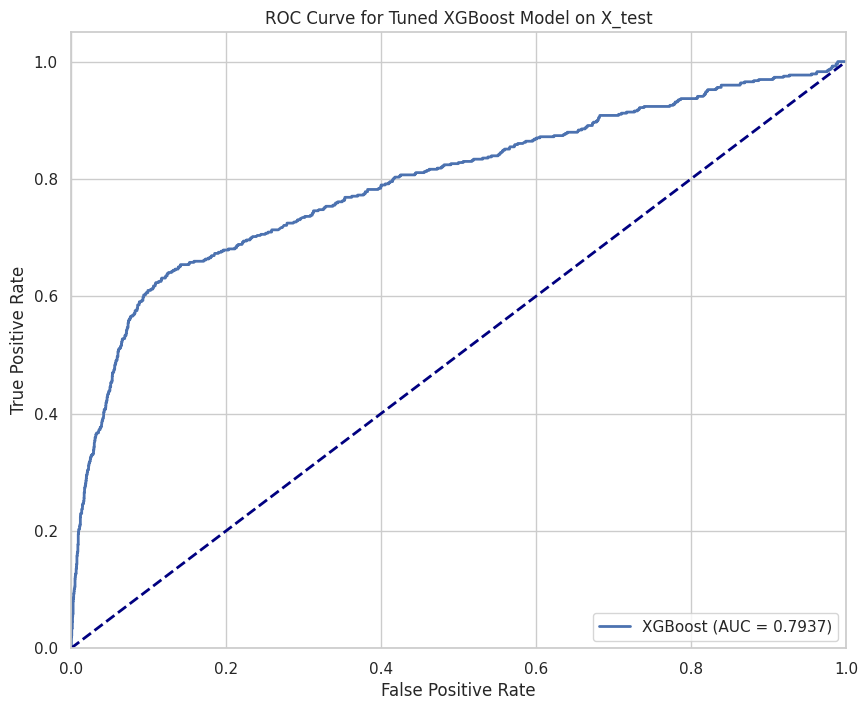


 Menyimpan File Submission 
File submission untuk XGBoost disimpan sebagai: /content/drive/MyDrive/KURSUS ARTIFICIAL INTELEGENT/Lomba Machine Learning/DCM_DMU_2025_Model_xgboost_Example.csv

Proses perbandingan model selesai.


In [12]:

print("\n Ringkasan Hasil Tuning Model")
for model_name, res in results.items():
    print(f"\nModel: {model_name}")
    print(f"   Best CV AUC: {res['best_cv_auc']:.4f}")
    print(f"   Test AUC: {res['test_auc']:.4f}")
    print(f"   Best Parameters: {res['best_params']}")


plt.figure(figsize=(10, 8))

if 'XGBoost' in results:
    y_pred_proba = best_xgb_estimator.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    plt.plot(fpr, tpr, lw=2, label=f'XGBoost (AUC = {results["XGBoost"]["test_auc"]:.4f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Tuned XGBoost Model on X_test')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

print("\n Menyimpan File Submission ")
for model_name, sub_df in submission_dfs.items():
    filename = f"/content/drive/MyDrive/KURSUS ARTIFICIAL INTELEGENT/Lomba Machine Learning/DCM_DMU_2025_Model_{model_name.lower().replace(' ', '_')}_Example.csv"
    sub_df.to_csv(filename, index=False)
    print(f"File submission untuk {model_name} disimpan sebagai: {filename}")

print("\nProses perbandingan model selesai.")